## Summary

Created: 10/20/2017 (cloned from HAT-P-44 b analysis and plotting (updated simultaneous best model))

In [ ]:
import datetime as dt

print(dt.datetime.now())

In [1]:
!python --version

Python 3.6.1 :: Continuum Analytics, Inc.


In [2]:
import os
os.environ['CONDA_DEFAULT_ENV']

'astroconda35'

## import and parse csv

In [3]:
import glob
import pandas as pd
import matplotlib.pyplot as pl
import numpy as np
%matplotlib inline
#import multiprocessing

pl.style.use('seaborn-white')
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
pl.rcParams['ytick.labelsize'] = 'large'
pl.rcParams['xtick.labelsize'] = 'large'

In [5]:
import getpass
from tqdm import tqdm

data_dir = '.'
file_list=glob.glob(data_dir+'/*band.csv')
file_list.sort()
len(file_list)

3

## import lc

In [6]:
pd.read_csv(file_list[0]).head().columns

Index(['GJD', 'GJD-2450000', 'flux', 'err', 'airmass', 'sky', 'dx', 'dy'], dtype='object')

In [7]:
data={}
bands='g,r,z'.split(',')

for i,(f,b) in enumerate(zip(file_list,bands)):
    df=pd.read_csv(os.path.join(data_dir,f), delimiter=',', parse_dates=True)
    #df.columns='GJD,GJD-2450000,flux,err,airmass,sky,dx,dy'.split(',')
    #df = df.set_index('BJD(TDB)-2450000')
    #df = df.set_index('GJD-2450000')
    df = df.set_index('GJD')
    data[b]=df

In [8]:
data[b].head()

,GJD-2450000,flux,err,airmass,sky,dx,dy
GJD,,,,,,,
2.457613e+06,7613.009172,1.003733,0.001649,2.1933,786.8,-9.351,1.157
2.457613e+06,7613.009797,1.000975,0.001636,2.1801,795.5,-7.690,2.054
2.457613e+06,7613.011661,1.001777,0.001596,2.1404,705.7,-7.904,2.675
2.457613e+06,7613.014149,1.001378,0.001548,2.0902,664.5,-8.042,2.828
2.457613e+06,7613.017911,1.000332,0.001482,2.0183,625.1,-7.606,2.288


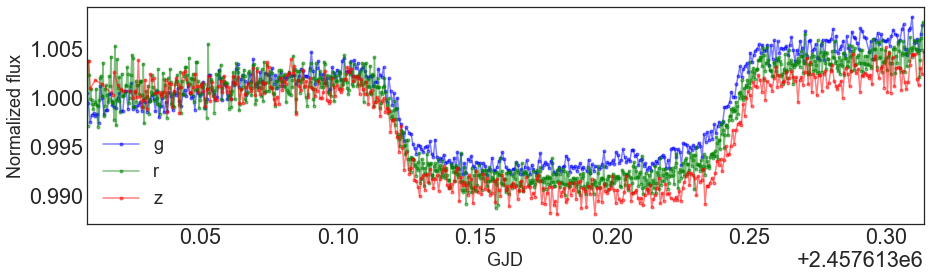

In [9]:
colors='b,g,r'.split(',')
fig,ax = pl.subplots(1,1,figsize=(15,4))
for (b,c) in zip(sorted(bands),colors):
    df = data[b]
    df.flux.plot(label=b, marker='.', color=c, alpha=0.5, ax=ax)
    ax.set_ylabel('Normalized flux')
pl.legend()

## building the model

* See [exoplanet.org](http://exoplanets.org/detail/WASP-21_b) for published transit parameters

In [10]:
from uncertainties import ufloat 

P   = ufloat(4.322482,2.4e-5) #+1.9×10-5/-2.4×10-5
Rp  = ufloat(1.070,0.06)
Rs  = ufloat(1.060,0.04) #Rsol
#tc  = ufloat(2454743.0419,0.0022) #+0.0019/-0.0022
t14 = ufloat(0.1398,0.004) #+0.0048/-0.004
b   = ufloat(0.23,0.1)     #0.23 +0.12/-0.15
a_s = ufloat(10.59,0.44)   #10.59 ± 0.44
k   = ufloat(0.01082,0.00037) #0.01082 +0.00037/-0.00035
rhop= ufloat(0.319,0.067)
inc = ufloat(88.75,0.8)       # +0.84/-0.7)

Convention:
* _P  : published value
* P_  : derived value
* P_0 : initial guess

In [23]:
_P   = 4.322482
_tc  = 2454743.0419
_t14 = 0.1398
_b   = 0.23
_a_s = 10.59
_k   = np.sqrt(0.01082)
_inc = np.deg2rad(88.75)

def scaled_a(p, t14, k, i=np.pi/2, impact_param=0):
    """
    Winn 2014 ("Transits and Occultations"), eq. 14
    """
    numer = np.sqrt( (k + 1)**2 - impact_param**2 )
    denom = np.sin(i) * np.sin(t14 * np.pi / p)
    return float(numer / denom)

a_s_=scaled_a(_P, _t14, _k, i=_inc, impact_param=_b)
a_s_

10.648013262755565

In [24]:
inc_ = np.arccos(_b/a_s_)
np.rad2deg(inc_)

88.762299226388166

In [25]:
from pytransit import MandelAgol
MA = MandelAgol()

def q_to_u(q1, q2):
    u1 = 2 * np.sqrt(q1) * q2
    u2 = np.sqrt(q1) * (1 - 2*q2)
    return u1, u2

def model_q(theta, t, p):
    '''
    p is an argument because it is well known from previous observation
    '''
    MA = MandelAgol()
    k,tc,a,b,q1,q2 = theta[:6]
    inc   = np.arccos(b/a)
    u1,u2 = q_to_u(q1, q2)
    model = MA.evaluate(t, k, (u1,u2), tc, p, a, inc)
    return model

In [29]:
tc_0 = 2.457613e6+0.19
q1_0, q2_0 = 0.4, 0.4

theta_true= [_k,tc_0,_a_s, _b, q1_0, q2_0]

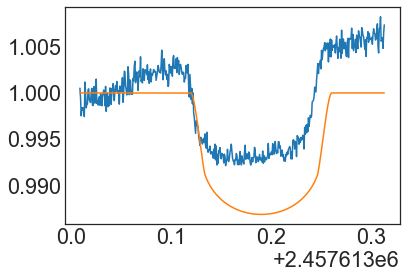

In [32]:
b='g'
f=data[b].flux
t=data[b].index

m=model_q(theta_true, t, _P)

pl.plot(data[b].index,f)
pl.plot(t,m)

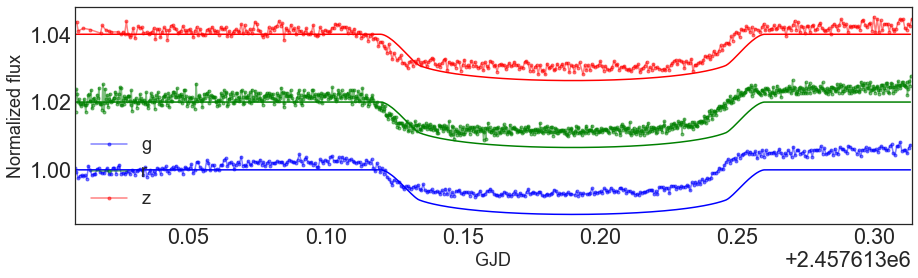

In [38]:
theta_vec = []

colors='b,g,r'.split(',')
fig,ax = pl.subplots(1,1,figsize=(15,4))
for i,(b,c) in enumerate(zip(sorted(bands),colors)):
    df = data[b]
    df.flux.apply(lambda x: x+0.02*i).plot(label=b, marker='.', color=c, alpha=0.5, ax=ax)
    #compute model
    k_0    = _k+0.001*i
    a_s_  = scaled_a(_P, _t14, k_0, i=_inc, impact_param=_b)
    theta = [k_0,tc_0,a_s_, _b, q1_0, q2_0]
    m=model_q(theta, t, _P)
    ax.plot(t,m+0.02*i,color=c)
    ax.set_ylabel('Normalized flux')
    theta_vec.append(theta)
pl.legend()

In [39]:
import scipy.optimize as op

def obj(theta, t, f, p):
    '''
    objective function is ordinary least squares
    c.f. chi-quared which includes point-wise sigma
    '''
    m = model_q(theta, t, p)
    return np.sum((m-f)**2)

In [40]:
ts = [data[b].index for b in sorted(bands)]
fluxes = [data[b]['flux'] for b in bands]

## MLE

* p, period
* k, r_planet/r_star
* t14, transit duration
* i, inclination
* b, impact paramter
* tc, mid-point transit time
* u1, u2, limb-darkening coeffs
* a_scaled

In [41]:
import scipy.optimize as op

def obj(theta, t, f, p):
    m = model_q(theta, t, p)
    return np.sum((m-f)**2)

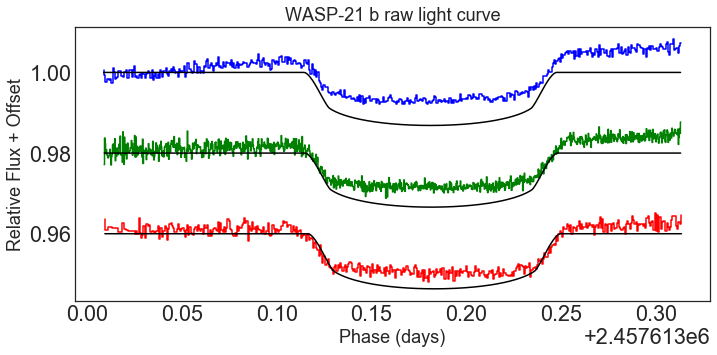

In [45]:
fontsize=18

ts,fluxes=[],[]
airmasses,uncs,dxs,dys=[],[],[],[]

colors='b,g,r'.split(',')

fig, axs = pl.subplots(1,1, figsize=(15,4), sharey=True)
for i,b in enumerate(sorted(bands)):
    d=data[b]
    #dropna
    #d=d.dropna(axis=0)    
    f=d['flux']
    t=f.index
    
    ts.append(t)
    fluxes.append(f)
    
    axs.plot(t,f-0.02*i, drawstyle='steps-mid', c=colors[i])
    res = op.minimize(obj, theta_vec[i], args=(t, f, _P), method='nelder-mead')
    model = model_q(res.x, t, _P)
    axs.plot(t, model-0.02*i, 'k-');
    
    fig.tight_layout()

    #sys mod params
    airmasses.append(d['airmass'])
    uncs.append(d['err'].values)
    #peak_fluxes.append(d['peak'].values)
    #fwhms.append(d['fwhm'].values)
    dxs.append(d['dx'].values)
    dys.append(d['dy'].values)
    
axs.set_title('WASP-21 b raw light curve',fontsize=fontsize)
axs.set_ylabel('Relative Flux + Offset',fontsize=fontsize)
axs.set_xlabel('Phase (days)',fontsize=fontsize)

In [46]:
#systematics model (time-dependent)
def model_s(theta, aux_vec, t):
    airmass, xcenter, ycenter = aux_vec
    #functional form of systematics model
    offset = np.ones(len(t))
    s = (np.array(theta)*np.c_[airmass, xcenter, ycenter, offset, t]).sum(axis=1)
    #s = [np.sum(c[k] * x**k) for k in np.arange(N)]
    # unpack 6 free params
    #a,b,c,d,e = theta
    #s = a + b*t + c*fwhm + d*xcenter + e*ycenter
    return s

def loglike(theta, t, f, p, aux_vec, ret_mod=False, ret_sys=False, ret_full = False):
    #airmass, xcenter, ycenter = aux_vec
    ls = theta[6]
    m = model_q(theta[:6], t, p)
    s = model_s(theta[7:], aux_vec, t) # #add sys model
    
    if ret_mod:
        return m
    if ret_sys:
        return s
    if ret_full:
        return m+s
    
    resid = f - m - s
    
    inv_sig2 = np.exp(-2*ls)
    
    return -0.5*(np.sum((resid)**2 * inv_sig2 + 2*ls))

#negative log-likelihood
nll = lambda *x: -loglike(*x)

--g--
NLL before: -2300.45190456041
NLL after: -2410.8842095009004
residual: std=0.0041, rms=0.0041
--r--
NLL before: -5337.13792892415
NLL after: -5503.700930714802
residual: std=0.0019, rms=0.0033
--z--
NLL before: -2368.6221678586935
NLL after: -2466.620610109765
residual: std=0.0015, rms=0.0026


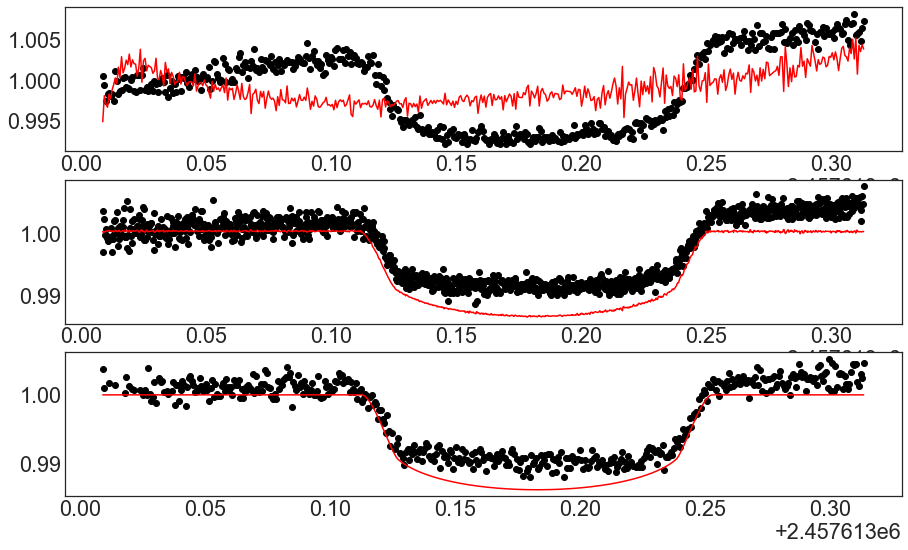

In [52]:
#systematics parameters
k0, k1, k2, k3, k4, k5, k6, k7, k8, k9 = [0]*10
#log flux uncertainty
k_list= [k0, k1, k2, k3, k4, k5, k6, k7, k8, k9]
nparams=5
ip = 0 #impact param, b
#parameters vector: 6 free, 7 input

import scipy.optimize as op
fig = pl.figure(figsize=(15,9))

for n,b in enumerate(sorted(bands)):
    d=data[b]
    #dropna
    #d=d.dropna(axis=0)
    #remove outliers
    #d=d[np.abs(d-d.mean())<=(3*d.std())]

    f=d['flux']
    t=f.index

    #sys mod params
    airmass = d['airmass'].values
    err=d['err'].values
    #peak_flux=d['peak(ADU)'].values
    #fwhm = d['fwhm(pix)'].values
    dx = d['dx'].values
    dy = d['dy'].values
    print('--{}--'.format(b))
    
    #parameters vector: 6 free, 3 input
    ls = np.log(np.nanstd(f))
    
    k_0    = _k+0.001*i
    a_s_  = scaled_a(_P, _t14, k_0, i=_inc, impact_param=_b)
    theta = [k_0,tc_0,a_s_, _b, q1_0, q2_0]
    theta_sys = np.concatenate((theta, [ls], k_list[:nparams]))
    
    aux_vec = (airmass, dx, dy)
    print ("NLL before: {}".format(nll(theta_sys, t, f, _P, aux_vec)))
    result = op.minimize(nll, theta_sys,    args=(t, f, _P, aux_vec), 
                         method='nelder-mead')
    print ("NLL after: {}".format(nll(result.x,   t, f, _P, aux_vec)))

    f_pred = loglike(result.x, t, f, _P, aux_vec, ret_full=True)
    mod    = loglike(result.x, t, f, _P, aux_vec, ret_mod=True)
    sys    = loglike(result.x, t, f, _P, aux_vec, ret_sys=True)
    resid=f-f_pred
    sigma=np.std(resid)
    rms=np.sqrt(np.mean(resid**2))
    print('residual: std={0:.4f}, rms={1:.4f}'.format(sigma, rms))
    
    ax = pl.subplot(3,1,n+1)
    ax.plot(t, f, 'ko', t, f_pred, 'r-');

## Limb-darkening prior
```
Uses table downloaded from:
http://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=J/A%2bA/529/A75/table-af
band must be one of: B C H I J K Kp R S1 S2 S3 S4 U V b g* i* r* u u* v y z*

log g below came from adopted model 11 (Table 11) of Hartmann+2014
```

In [53]:
import limbdark as lb

teff, uteff, logg, ulogg, feh, ufeh=5800.0,100.0,4.2,0.1, -0.46, 0.11

#limbdark priors
ldp = []
for i in 'g*,r*,z*'.split(','):
    ldp.append(lb.claret(i, teff, uteff, logg, ulogg, feh, ufeh, n=int(1e4)))

## MCMC

Note the [difference](https://stats.stackexchange.com/questions/74082/what-is-the-difference-in-bayesian-estimate-and-maximum-likelihood-estimate) in interpretation of their results.

In [54]:
theta

[0.10601922899156675, 2457613.19, 10.66817715302229, 0.23, 0.4, 0.4]

In [55]:
from scipy import stats
def logprior(theta,up=None):
    k,tc,a,impact_param,q1,q2 = theta[:6]
    inc=np.arccos(impact_param/a)
    
    
    #or k from 0 up to order of max_k (Seager paper)?
    if  q1  < 0 or q1 > 1 or \
        q2  < 0 or q2 > 1 or \
        k   < 0 or k  > 1 or \
        impact_param   < 0 or impact_param  > 1 or \
        inc > np.pi/2     or \
        a   < 0 or a  > 100 or \
        tc < t[0] or tc > t[-1]:
            
        print('off limits encountered in logprior')
        return -np.inf

    lp = 0
    #u prior
    u1,u2 = q_to_u(q1,q2)
    
    if up is not None:
        lp += np.log(stats.norm.pdf(u1, loc=up[0], scale=up[1]))
        lp += np.log(stats.norm.pdf(u2, loc=up[2], scale=up[3]))
    
    return lp

def logprob(theta_sys,ts,fluxes,p,airmasses,dxs,dys,up=None):
    t1,t2,t3 = ts
    f1,f2,f3 = fluxes
    airmass1,airmass2,airmass3 = airmasses
    xcen1,xcen2,xcen3 = dxs
    ycen1,ycen2,ycen3 = dys
    k1,k2,k3,tc,a1,a2,a3,impact_param,q11,q12,q13,q21,q22,q23,ls1,ls2,ls3,\
    k01,k02,k03,k11,k12,k13,k21,k22,k23,k31,k32,k33,k41,k42,k43 = theta_sys
    
    theta1 = [k1,tc,a1,impact_param,q11,q21,ls1,k01,k11,k21,k31,k41]
    theta2 = [k2,tc,a2,impact_param,q12,q22,ls2,k02,k12,k22,k32,k42]
    theta3 = [k3,tc,a3,impact_param,q13,q23,ls3,k03,k13,k23,k33,k43]
    
    aux_vec1 = airmass1, xcen1, ycen1
    aux_vec2 = airmass2, xcen2, ycen2
    aux_vec3 = airmass3, xcen3, ycen3
    
    #sum loglike for each band
    ll  = loglike(theta1, t1, f1, p, aux_vec1)
    ll += loglike(theta2, t2, f2, p, aux_vec2)
    ll += loglike(theta3, t3, f3, p, aux_vec3)
    
    if up is not None:
        lp  = logprior(theta1,up=up[0])
        lp += logprior(theta2,up=up[1])
        lp += logprior(theta3,up=up[2])
    else:
        lp  = logprior(theta1)
        lp += logprior(theta2)
        lp += logprior(theta3)
    
    if np.isnan(ll).any():
        print('NaN encountered in loglike')
        return -np.inf
    
    #total: sum of prior and likelihood
    return lp + ll

#negative log prob
nlp = lambda *x: -logprob(*x)

sanity check

In [57]:
theta_vec=[]
for i,j in enumerate(bands):
    #a.append(scaled_a(p_, t14_, k_, inc=np.pi/2))
    k_0    = _k+0.001*i
    a_s_  = scaled_a(_P, _t14, k_0, i=_inc, impact_param=_b)
    theta = [k_0,tc_0,a_s_, _b, q1_0, q2_0]
    theta.append(theta_vec)

k1,k2,k3     = [_k+0.001,_k+0.002,_k+0.002]  
q11,q12, q13 = [0.4] * 3
q21,q22, q23 = [0.4] * 3
a1,a2,a3     = [a_s_]* 3

#systematics parameters
k01, k11, k21, k31, k41 = [0] * 5
k02, k12, k22, k32, k42 = [0] * 5
k03, k13, k23, k33, k43 = [0] * 5


#log flux uncertainty
ls1,ls2,ls3 = [np.log(np.nanstd(f)) for f in fluxes]  
t1,t2,t3         = ts
f1,f2,f3         = fluxes
xcen1,xcen2,xcen3= dxs
ycen1,ycen2,ycen3= dys
airmass1,airmass2,airmass3=airmasses
#fwhm1,fwhm2,fwhm3= fwhms
#unc1,unc2,unc3   = uncs

In [61]:
theta_sys = [k1,k2,k3,tc_0,a1,a2,a3,_b,q11,q12,q13,q21,q22,q23,ls1,ls2,ls3,k01,k02,k03,k11,k12,k13,k21,k22,k23,k31,k32,k33,k41,k42,k43]
args = [ts,fluxes,_P,airmasses,dxs,dys]

In [62]:
#without ldp
logprob(theta_sys, *args)

10018.767453179526

In [63]:
#with ldp
logprob(theta_sys, *args, up=ldp)

9845.4476822057204

In [64]:
from emcee import MHSampler, EnsembleSampler
from emcee.utils import sample_ball
from tqdm import tqdm

ndim = len(theta_sys)
nwalkers = 8 * ndim if ndim > 12 else 16 * ndim
nsteps1 = 1000

sampler = EnsembleSampler(nwalkers, ndim, logprob, args=args, threads=1)

#random initial condition
pos0 = sample_ball(theta_sys, [1e-4]*ndim, nwalkers)
'''pos0 = [np.array(initial) + 1e-8 * np.random.randn(ndim)
      for i in xrange(nwalkers)]'''

#begin
for pos,lnp,rstate in tqdm(sampler.sample(pos0, iterations=nsteps1)):
    pass

770it [35:55,  2.68s/it]/home/jp/miniconda3/envs/astroconda35/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/home/jp/miniconda3/envs/astroconda35/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


off limits encountered in logprior


771it [35:57,  2.34s/it]

off limits encountered in logprior


816it [38:16,  2.91s/it]

off limits encountered in logprior


820it [38:24,  2.36s/it]

off limits encountered in logprior


824it [38:34,  2.26s/it]

off limits encountered in logprior


837it [39:01,  2.67s/it]

off limits encountered in logprior


841it [39:16,  3.36s/it]

off limits encountered in logprior


847it [39:32,  2.37s/it]

off limits encountered in logprior
off limits encountered in logprior


848it [39:34,  2.14s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


850it [39:41,  2.64s/it]

off limits encountered in logprior


853it [39:47,  2.33s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


854it [39:49,  2.15s/it]

off limits encountered in logprior


856it [39:56,  2.69s/it]

off limits encountered in logprior
off limits encountered in logprior


857it [39:58,  2.50s/it]

off limits encountered in logprior


858it [40:02,  3.02s/it]

off limits encountered in logprior
off limits encountered in logprior


859it [40:04,  2.75s/it]

off limits encountered in logprior


860it [40:06,  2.44s/it]

off limits encountered in logprior


861it [40:09,  2.69s/it]

off limits encountered in logprior
off limits encountered in logprior


862it [40:11,  2.51s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


863it [40:13,  2.31s/it]

off limits encountered in logprior
off limits encountered in logprior


864it [40:15,  2.23s/it]

off limits encountered in logprior


865it [40:18,  2.50s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


866it [40:20,  2.37s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


867it [40:22,  2.18s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


868it [40:24,  2.08s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


869it [40:25,  1.91s/it]

off limits encountered in logprior


870it [40:27,  1.85s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


871it [40:29,  1.86s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


872it [40:33,  2.37s/it]

off limits encountered in logprior
off limits encountered in logprior


873it [40:37,  3.01s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


874it [40:39,  2.75s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


875it [40:41,  2.43s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


876it [40:43,  2.30s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


877it [40:46,  2.63s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


878it [40:48,  2.31s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


879it [40:49,  2.09s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


880it [40:52,  2.37s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


881it [40:55,  2.47s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


882it [40:57,  2.26s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


883it [40:59,  2.34s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


884it [41:03,  2.62s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


885it [41:04,  2.33s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


886it [41:06,  2.15s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


887it [41:10,  2.75s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


888it [41:12,  2.46s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


889it [41:14,  2.20s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


890it [41:17,  2.54s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


891it [41:19,  2.45s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


892it [41:21,  2.28s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


893it [41:24,  2.39s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


894it [41:27,  2.57s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


895it [41:28,  2.28s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


896it [41:30,  2.06s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


897it [41:34,  2.55s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


898it [41:36,  2.37s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


899it [41:37,  2.13s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


900it [41:40,  2.21s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


901it [41:43,  2.52s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


902it [41:44,  2.23s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


903it [41:46,  2.15s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


904it [41:50,  2.70s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


905it [41:52,  2.46s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


906it [41:54,  2.23s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


907it [41:58,  2.82s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


908it [42:00,  2.50s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


909it [42:02,  2.28s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


910it [42:05,  2.54s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


911it [42:07,  2.60s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


912it [42:09,  2.37s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior

913it [42:12,  2.58s/it]


off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior

914it [42:15,  2.71s/it]


off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


915it [42:17,  2.40s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


916it [42:20,  2.65s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


917it [42:23,  2.74s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


918it [42:25,  2.47s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


919it [42:27,  2.45s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


920it [42:31,  2.89s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


921it [42:33,  2.64s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


922it [42:37,  2.93s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


923it [42:40,  2.91s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


924it [42:42,  2.67s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


925it [42:46,  3.17s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


926it [42:48,  2.79s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

927it [42:50,  2.50s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


928it [42:55,  3.08s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


929it [42:57,  2.75s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

930it [42:59,  2.66s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


931it [43:03,  3.06s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


932it [43:05,  2.70s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


933it [43:09,  3.01s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


934it [43:12,  2.99s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


935it [43:14,  2.74s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


936it [43:19,  3.44s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


937it [43:20,  2.88s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


938it [43:22,  2.52s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


939it [43:26,  2.88s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


940it [43:29,  2.86s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


941it [43:32,  2.94s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


942it [43:35,  3.09s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


943it [43:37,  2.76s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

944it [43:41,  3.08s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


945it [43:44,  2.99s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


946it [43:45,  2.47s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

947it [43:47,  2.28s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


948it [43:51,  2.76s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


949it [43:52,  2.33s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


950it [43:53,  2.02s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


951it [43:56,  2.16s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


952it [43:59,  2.56s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

953it [44:01,  2.31s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

954it [44:04,  2.58s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


955it [44:07,  2.72s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


956it [44:09,  2.49s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


957it [44:12,  2.62s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


958it [44:16,  2.87s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

959it [44:17,  2.50s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


960it [44:21,  2.94s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


961it [44:24,  2.77s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


962it [44:26,  2.56s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


963it [44:30,  3.09s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


964it [44:33,  3.13s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


965it [44:38,  3.51s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


966it [44:40,  3.26s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

967it [44:42,  2.88s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


968it [44:47,  3.42s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


969it [44:49,  2.92s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


970it [44:50,  2.52s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


971it [44:55,  3.14s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


972it [44:57,  2.77s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

973it [44:59,  2.62s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


974it [45:04,  3.21s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


975it [45:06,  2.84s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


976it [45:10,  3.18s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


977it [45:12,  2.98s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


978it [45:14,  2.57s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


979it [45:17,  2.75s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


980it [45:20,  2.76s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


981it [45:21,  2.35s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


982it [45:22,  2.08s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


983it [45:28,  2.96s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


984it [45:30,  2.72s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


985it [45:33,  3.00s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

986it [45:36,  2.85s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


987it [45:38,  2.63s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


988it [45:43,  3.30s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


989it [45:45,  2.92s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


990it [45:47,  2.80s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


991it [45:51,  3.13s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


992it [45:53,  2.85s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


993it [45:58,  3.25s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

994it [46:00,  3.03s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


995it [46:02,  2.80s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


996it [46:07,  3.28s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


997it [46:09,  2.94s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


998it [46:12,  2.89s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

999it [46:15,  3.13s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


1000it [46:17,  2.81s/it]

off limits encountered in logprior


## Initial results: Parameter best estimates (including burn-in)

In [65]:
#save gzip

chain=sampler.chain
import gzip
loc='./mcmc/'
with gzip.GzipFile(os.path.join(loc,'chain1.npy.gz'), "w") as g:
    np.save(g, chain)
#np.allclose(sample_chain.shape,chain.shape)

In [21]:
import gzip
#load gzip
loc='./mcmc/'
#with gzip.GzipFile(os.path.join(loc,'best_model_1.npy.gz'), "r") as g:
with gzip.GzipFile(os.path.join(loc,'chain1.npy.gz'), "r") as g:
    chain=np.load(g)

NameError: name 'plt' is not defined

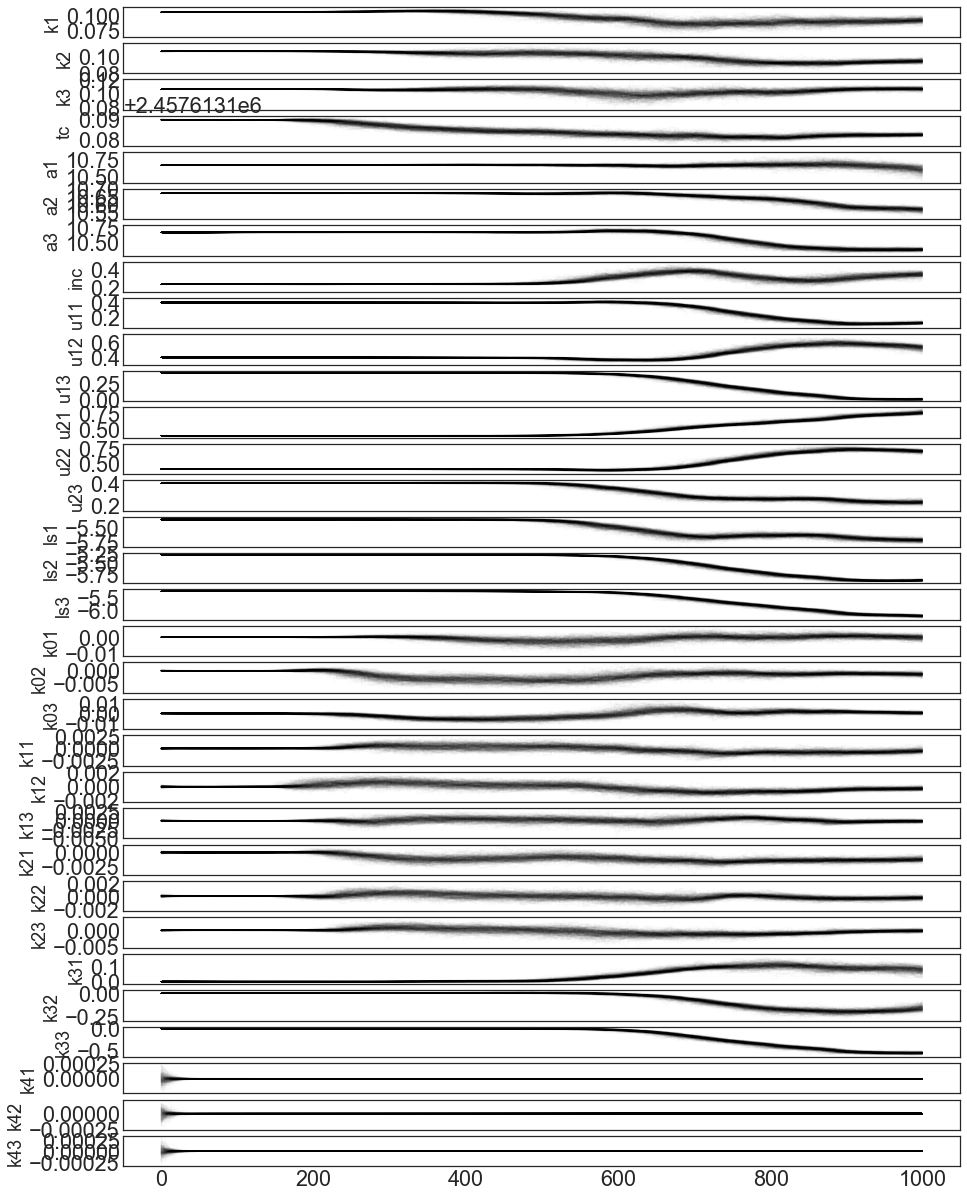

In [67]:
pl.style.use('seaborn-white')

param_names='k1,k2,k3,tc,a1,a2,a3,inc,u11,u12,u13,u21,u22,u23,ls1,ls2,ls3,k01,k02,k03,k11,k12,k13,k21,k22,k23,k31,k32,k33,k41,k42,k43'.split(',')

nwalkers, nsteps, ndim = chain.shape
fig, axs = pl.subplots(ndim, 1, figsize=(15,ndim/1.5), sharex=True)
#ls, lc = ['-','--','--'], ['k', '0.5', '0.5']
#percs = [np.percentile(sampler.chain2[:,:,i], [50,16,84], 0) for i in range(ndim)]
[axs.flat[i].plot(c, drawstyle='steps', color='k', alpha=4./nwalkers) for i,c in enumerate(chain.T)]
#[[axs.flat[i].plot(percs[i][j], c=lc[j], ls=ls[j]) for j in range(3)] for i in range(ndim)]
[axs.flat[i].set_ylabel(l) for i,l in enumerate(param_names)]
    
pl.xlabel('nsteps')

# re-calculate logprob

In [26]:
burn=1000
thin=100

fc = chain2[:,burn::thin,:].reshape([-1,chain2.shape[-1]])
fc.shape

(23040, 32)

In [38]:
fc_lnprob=[logprob(th, *args) for th in tqdm(fc)]

#fc_lnp = np.load(os.path.join(loc,'best_model_long_lnp1.npy'))
#fc_lnp.shape

100%|██████████| 23040/23040 [02:09<00:00, 177.66it/s]


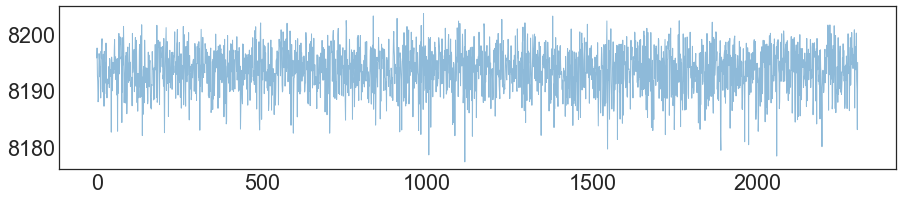

In [30]:
fig=plt.figure(figsize=(15,3))
plt.plot(fc_lnprob[::10], lw=1, alpha=0.5)